# Natural Language Preprocessing and Word Vectors


In this notebook, we clean up a dataset of natural language data (books from Project Gutenberg) and use word2vec to embed the language in word vectors.

**N.B.:** Some, all or none of these preprocessing steps may be helpful to a given downstream application.


In [1]:
%pip install gensim

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NSC-BS-CS/CSB410_Labs/blob/main/BookLabs/8-natural_language_preprocessing.ipynb)


#### Load dependencies


In [2]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure
%matplotlib inline

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Load Data


In [3]:
from nltk.corpus import gutenberg

In [4]:
len(gutenberg.fileids())

18

In [5]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [6]:
len(gutenberg.words())

2621613

In [7]:
gberg_sent_tokens = sent_tokenize(gutenberg.raw())

In [8]:
gberg_sent_tokens[0:6]

['[Emma by Jane Austen 1816]\n\nVOLUME I\n\nCHAPTER I\n\n\nEmma Woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.',
 "She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.",
 'Her mother\nhad died too long ago for her to have more than an indistinct\nremembrance of her caresses; and her place had been supplied\nby an excellent woman as governess, who had fallen little short\nof a mother in affection.',
 "Sixteen years had Miss Taylor been in Mr. Woodhouse's family,\nless as a governess than a friend, very fond of both daughters,\nbut particularly of Emma.",
 'Between _them_ it was more the intimacy\nof sisters.',
 "Even before Miss Taylor had ceased to hold the nominal

In [9]:
gberg_sent_tokens[1]

"She was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period."

In [10]:
word_tokenize(gberg_sent_tokens[1])

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'s",
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

In [11]:
word_tokenize(gberg_sent_tokens[1])[14]

'father'

In [12]:
# a convenient method that handles newlines, as well as tokenizing sentences and words in one shot
gberg_sents = gutenberg.sents()

In [13]:
gberg_sents[0:6]

[['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']'],
 ['VOLUME', 'I'],
 ['CHAPTER', 'I'],
 ['Emma',
  'Woodhouse',
  ',',
  'handsome',
  ',',
  'clever',
  ',',
  'and',
  'rich',
  ',',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  ',',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  ';',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  '-',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her',
  '.'],
 ['She',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  ',',
  'indulgent',
  'father',
  ';',
  'and',
  'had',
  ',',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  "'",
  's',
  'marriage',
  ',',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period',
  '.'],
 ['Her',
  'mother',
  'h

In [14]:
gberg_sents[4][14]

'father'

#### Iteratively preprocess a sentence


##### a tokenized sentence:


In [15]:
gberg_sents[4]

['She',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### to lowercase:


In [16]:
[w.lower() for w in gberg_sents[4]]

['she',
 'was',
 'the',
 'youngest',
 'of',
 'the',
 'two',
 'daughters',
 'of',
 'a',
 'most',
 'affectionate',
 ',',
 'indulgent',
 'father',
 ';',
 'and',
 'had',
 ',',
 'in',
 'consequence',
 'of',
 'her',
 'sister',
 "'",
 's',
 'marriage',
 ',',
 'been',
 'mistress',
 'of',
 'his',
 'house',
 'from',
 'a',
 'very',
 'early',
 'period',
 '.']

##### remove stopwords and punctuation:


In [17]:
stpwrds = stopwords.words('english') + list(string.punctuation)

In [18]:
stpwrds

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [19]:
[w.lower() for w in gberg_sents[4] if w.lower() not in stpwrds]

['youngest',
 'two',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period']

##### stem words:


In [20]:
stemmer = PorterStemmer()

In [21]:
[stemmer.stem(w.lower()) for w in gberg_sents[4]
 if w.lower() not in stpwrds]

['youngest',
 'two',
 'daughter',
 'affection',
 'indulg',
 'father',
 'consequ',
 'sister',
 'marriag',
 'mistress',
 'hous',
 'earli',
 'period']

##### handle bigram collocations:


In [22]:
phrases = Phrases(gberg_sents) # train detector

In [23]:
bigram = Phraser(phrases) # create a more efficient Phraser object for transforming sentences

In [24]:
bigram.phrasegrams # output count and score of each bigram

{'two_daughters': 11.966813731181547,
 'her_sister': 17.7960829227865,
 "'_s": 31.066242737744524,
 'very_early': 11.01214147275924,
 'Her_mother': 13.529425062715127,
 'long_ago': 63.22343628984789,
 'more_than': 29.023584433996874,
 'had_been': 22.306024648925288,
 'an_excellent': 39.063874851750626,
 'Miss_Taylor': 453.75918026073305,
 'very_fond': 24.134280468850747,
 'passed_away': 12.35053642325912,
 'too_much': 31.376002029426687,
 'did_not': 11.72841621714281,
 'any_means': 14.096964108090186,
 'wedding_-': 17.4695197740113,
 'Her_father': 13.129571562488772,
 'after_dinner': 21.528548116881705,
 'self_-': 47.79018053120332,
 'sixteen_years': 107.0461671612265,
 'five_years': 40.128755673408115,
 'years_old': 54.735425236061104,
 'seven_years': 52.59411150244507,
 'each_other': 79.4168405322873,
 'a_mile': 12.783091600264584,
 'must_be': 10.229989650632808,
 'difference_between': 220.52537305244678,
 'could_not': 10.870983286982371,
 'having_been': 11.53801833156938,
 'miles_of

In [25]:
tokenized_sentence = "Jon lives in New York City".split()

In [26]:
tokenized_sentence

['Jon', 'lives', 'in', 'New', 'York', 'City']

In [27]:
bigram[tokenized_sentence]

['Jon', 'lives', 'in', 'New_York', 'City']

#### Preprocess the corpus


In [28]:
# as in Maas et al. (2001):
# - leave in stop words ("indicative of sentiment")
# - no stemming ("model learns similar representations of words of the same stem when data suggests it")
lower_sents = []
for s in gberg_sents:
    lower_sents.append([w.lower() for w in s if w.lower()
                        not in list(string.punctuation)])

In [29]:
lower_sents[0:5]

[['emma', 'by', 'jane', 'austen', '1816'],
 ['volume', 'i'],
 ['chapter', 'i'],
 ['emma',
  'woodhouse',
  'handsome',
  'clever',
  'and',
  'rich',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her'],
 ['she',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  'indulgent',
  'father',
  'and',
  'had',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  's',
  'marriage',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period']]

In [30]:
lower_bigram = Phraser(Phrases(lower_sents))

In [31]:
lower_bigram.phrasegrams # miss taylor, mr woodhouse, mr weston

{'two_daughters': 11.080802900992637,
 'her_sister': 16.93971298099339,
 'very_early': 10.516998773665177,
 'her_mother': 10.70812618607742,
 'long_ago': 59.22644201533601,
 'more_than': 28.529926612065935,
 'had_been': 21.583193129694834,
 'an_excellent': 37.41859680854167,
 'sixteen_years': 131.42913000977518,
 'miss_taylor': 420.4340982546865,
 'mr_woodhouse': 104.19907841850323,
 'very_fond': 24.185726346489627,
 'passed_away': 11.751473221742694,
 'too_much': 30.363090173835406,
 'did_not': 10.846196223896685,
 'any_means': 14.294148100212627,
 'after_dinner': 18.60737125272944,
 'mr_weston': 91.63290824201266,
 'five_years': 37.66428596665674,
 'years_old': 48.59909444619029,
 'seven_years': 50.3345604292756,
 'each_other': 71.31277029783762,
 'well_informed': 14.185028016786626,
 'a_mile': 11.700110753652233,
 'difference_between': 207.86784241868986,
 'mrs_weston': 180.6778969011602,
 'could_not': 10.213333164207082,
 'having_been': 10.723750443105281,
 'sixteen_miles': 105.040

In [32]:
lower_bigram["jon lives in new york city".split()]

['jon', 'lives', 'in', 'new_york', 'city']

In [33]:
lower_bigram = Phraser(Phrases(lower_sents,
                               min_count=32, threshold=64))
lower_bigram.phrasegrams

{'miss_taylor': 156.44059469941823,
 'mr_woodhouse': 82.04651843976633,
 'mr_weston': 75.87438262077481,
 'mrs_weston': 160.6848509325892,
 'great_deal': 93.36368125424357,
 'mr_knightley': 161.74131790625913,
 'miss_woodhouse': 229.03802722366902,
 'years_ago': 74.31594785893046,
 'mr_elton': 121.3990121932397,
 'dare_say': 89.94000515807346,
 'frank_churchill': 1316.4456593286038,
 'miss_bates': 276.3958829169252,
 'drawing_room': 84.91494947493561,
 'mrs_goddard': 143.57843432545658,
 'miss_smith': 73.03442128232508,
 'few_minutes': 204.16834974753786,
 'john_knightley': 83.03755747111268,
 'don_t': 250.30957446808512,
 'good_natured': 88.69936184891343,
 'few_moments': 107.77584531675087,
 'thousand_pounds': 166.51834523092802,
 'o_clock': 89.14789088153574,
 'jane_fairfax': 654.556591758761,
 'miss_fairfax': 196.19987447261062,
 'ma_am': 157.25846601094193,
 'mrs_elton': 93.08931456265867,
 'forty_years': 90.60220877269607,
 'cut_off': 129.60290535032792,
 'ten_thousand': 84.00099

In [34]:
clean_sents = []
for s in lower_sents:
    clean_sents.append(lower_bigram[s])

In [35]:
clean_sents[0:9]

[['emma', 'by', 'jane', 'austen', '1816'],
 ['volume', 'i'],
 ['chapter', 'i'],
 ['emma',
  'woodhouse',
  'handsome',
  'clever',
  'and',
  'rich',
  'with',
  'a',
  'comfortable',
  'home',
  'and',
  'happy',
  'disposition',
  'seemed',
  'to',
  'unite',
  'some',
  'of',
  'the',
  'best',
  'blessings',
  'of',
  'existence',
  'and',
  'had',
  'lived',
  'nearly',
  'twenty',
  'one',
  'years',
  'in',
  'the',
  'world',
  'with',
  'very',
  'little',
  'to',
  'distress',
  'or',
  'vex',
  'her'],
 ['she',
  'was',
  'the',
  'youngest',
  'of',
  'the',
  'two',
  'daughters',
  'of',
  'a',
  'most',
  'affectionate',
  'indulgent',
  'father',
  'and',
  'had',
  'in',
  'consequence',
  'of',
  'her',
  'sister',
  's',
  'marriage',
  'been',
  'mistress',
  'of',
  'his',
  'house',
  'from',
  'a',
  'very',
  'early',
  'period'],
 ['her',
  'mother',
  'had',
  'died',
  'too',
  'long',
  'ago',
  'for',
  'her',
  'to',
  'have',
  'more',
  'than',
  'an',
 

In [36]:
clean_sents[6]

['sixteen',
 'years',
 'had',
 'miss_taylor',
 'been',
 'in',
 'mr_woodhouse',
 's',
 'family',
 'less',
 'as',
 'a',
 'governess',
 'than',
 'a',
 'friend',
 'very',
 'fond',
 'of',
 'both',
 'daughters',
 'but',
 'particularly',
 'of',
 'emma']

#### Run word2vec


In [37]:
# max_vocab_size can be used instead of min_count (which has increased here)
model = Word2Vec(sentences=clean_sents, vector_size=64,
                 sg=1, window=10, epochs=5,
                 min_count=10, workers=4)
model.save('clean_gutenberg_model.w2v')

#### Explore model


In [38]:
# skip re-training the model with the next line:
model = gensim.models.Word2Vec.load('clean_gutenberg_model.w2v')

In [39]:
len(model.wv.key_to_index) # would be 17k if we carried out no preprocessing

10329

In [40]:
model.wv['dog']

array([-0.0829581 , -0.36002618,  0.32477078,  0.02917115,  0.22721447,
        0.0161297 , -0.00969343,  0.20662704, -0.25311077, -0.02205828,
       -0.23688272, -0.24891098,  0.01059611,  0.08072023, -0.5183167 ,
       -0.37481454,  0.1505354 ,  0.63430756, -0.5761345 ,  0.14035383,
        0.25597972,  0.11958852,  0.3264897 , -0.1675615 , -0.48467067,
        0.3517884 , -0.1004865 ,  0.37363815,  0.138939  , -0.35513082,
       -0.15657544, -0.29774687, -0.36004245, -0.3461313 ,  0.02717221,
       -0.15262748,  0.23183824, -0.1877094 , -0.00586585,  0.5780874 ,
       -0.4873706 ,  0.00180123,  0.0280467 , -0.10487839, -0.06782009,
        0.33938432, -0.35247013,  0.02049572, -0.28974262,  0.6284391 ,
       -0.28816408,  0.41003713,  0.20065275,  0.08292143, -0.02933017,
       -0.33793455,  0.06372761,  0.03533053, -0.03236113,  0.40849492,
       -0.00947673, -0.2803818 , -0.55880433, -0.06505978], dtype=float32)

In [41]:
len(model.wv['dog'])

64

In [42]:
model.wv.most_similar('dog', topn=3)

[('puppy', 0.8080946207046509),
 ('broth', 0.7517848610877991),
 ('pet', 0.7454079985618591)]

In [43]:
model.wv.most_similar('eat', topn=3)

[('bread', 0.8342103362083435),
 ('drink', 0.7966364622116089),
 ('meat', 0.7639804482460022)]

In [44]:
model.wv.most_similar('day', topn=3)

[('night', 0.7932251691818237),
 ('morning', 0.7554266452789307),
 ('week', 0.7335723638534546)]

In [45]:
model.wv.most_similar('father', topn=3)

[('mother', 0.8213990330696106),
 ('sister', 0.7618507742881775),
 ('brother', 0.7540510296821594)]

In [46]:
model.wv.most_similar('ma_am', topn=3)

[('madam', 0.8520761132240295),
 ('betty', 0.8467086553573608),
 ("'--", 0.8264241814613342)]

In [47]:
model.wv.doesnt_match("mother father sister brother dog".split())

'dog'

In [48]:
model.wv.similarity('father', 'dog')

0.46885753

In [49]:
model.wv.most_similar(positive=['father', 'woman'], negative=['man'])

[('sister', 0.7825110554695129),
 ('mother', 0.7645965218544006),
 ('wife', 0.7424109578132629),
 ('daughter', 0.7350651025772095),
 ('husband', 0.7317769527435303),
 ('child', 0.6994935870170593),
 ('tamar', 0.6900143027305603),
 ('sarah', 0.6731537580490112),
 ('daughters', 0.6716527342796326),
 ('nurse', 0.6712668538093567)]

In [50]:
model.wv.most_similar(positive=['husband', 'woman'], negative=['man'])

[('wife', 0.69715815782547),
 ('sister', 0.6957176923751831),
 ('daughter', 0.6679406762123108),
 ('maid', 0.6590021848678589),
 ('nurse', 0.6464770436286926),
 ('mother', 0.6435787081718445),
 ('conceived', 0.6427346467971802),
 ('child', 0.6314283609390259),
 ('tamar', 0.608337938785553),
 ('womb', 0.5956907272338867)]

#### Reduce word vector dimensionality with t-SNE


In [51]:
tsne = TSNE(n_components=2, n_iter=1000)

In [52]:
X_2d = tsne.fit_transform(model.wv[model.wv.key_to_index])

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [53]:
coords_df = pd.DataFrame(X_2d, columns=['x','y'])
coords_df['token'] = model.wv.key_to_index.keys()

In [54]:
# coords_df.head()

In [55]:
coords_df.to_csv('clean_gutenberg_tsne.csv', index=False)

#### Visualise


In [56]:
coords_df = pd.read_csv('clean_gutenberg_tsne.csv')

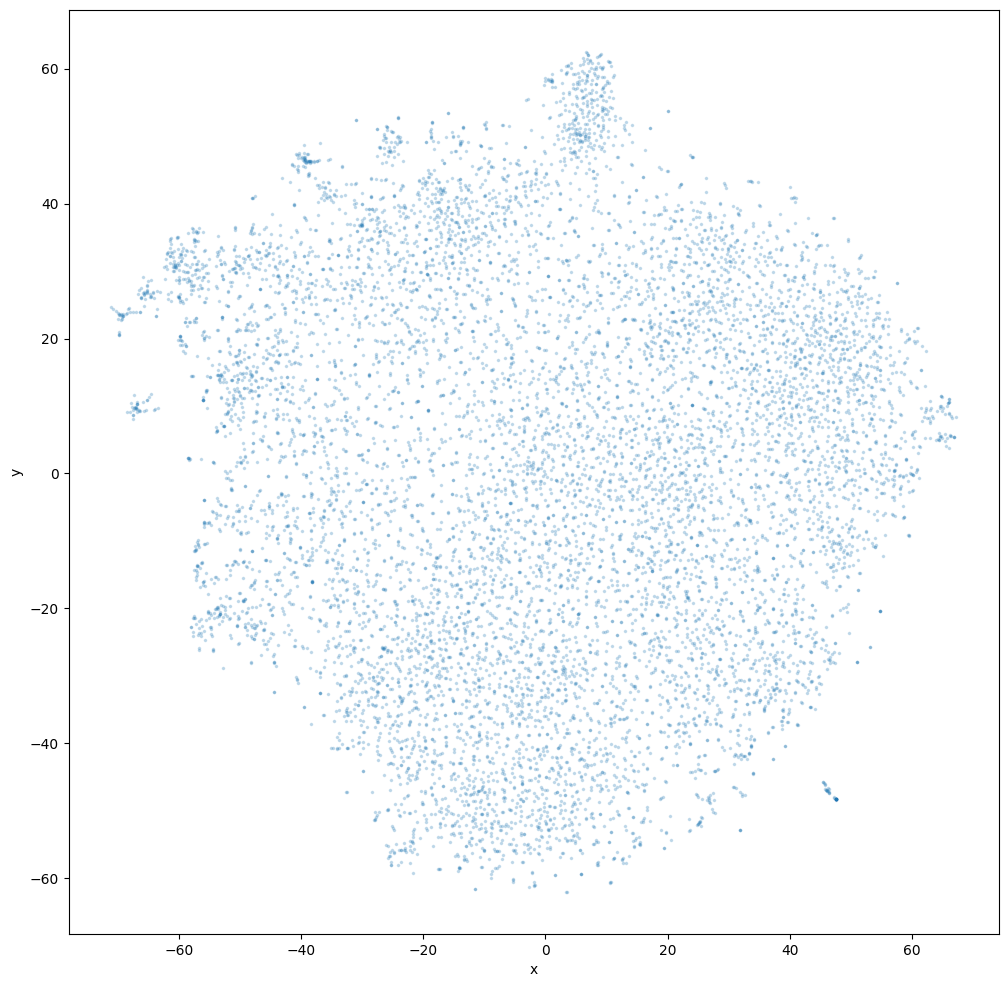

In [57]:
_ = coords_df.plot.scatter('x', 'y', figsize=(12,12),
                           marker='.', s=10, alpha=0.2)

In [58]:
output_notebook()

In [59]:
subset_df = coords_df.sample(n=5000)

In [61]:
p = figure(width=800, height=800)
_ = p.text(x=subset_df.x, y=subset_df.y, text=subset_df.token)

In [62]:
show(p)

In [ ]:
# output_file() here